# RQ3: Distribution 

## Euler Diagram

{'tdebatty_java-string-similarityRatcliffObershelp92', 'BlueObelisk_euclidLine2144', 'BlueObelisk_euclidReal3Range78', 'bvolpato_inutils4jMyStringUtils672', 'facebook_facebook-java-business-sdkBatchProcessor30', 'facebook_facebook-java-business-sdkServerSideApiUtil196', 'tdebatty_java-string-similaritySorensenDice70', 'tdebatty_java-string-similarityRatcliffObershelp47', 'facebook_facebook-java-business-sdkEvent385', 'facebook_facebook-java-business-sdkEvent425', 'facebook_facebook-java-business-sdkEvent1605', 'facebook_facebook-java-business-sdkEvent632', 'facebook_facebook-java-business-sdkCAPIGatewayEndpoint14', 'BlueObelisk_euclidLine2455', 'bvolpato_inutils4jMyStringUtils2073', 'bvolpato_inutils4jMyStringUtils610', 'facebook_facebook-java-business-sdkEvent1879', 'facebook_facebook-java-business-sdkEvent673', 'facebook_facebook-java-business-sdkEvent901', 'tabulapdf_tabula-javaRectangle120', 'bvolpato_inutils4jMyArrUtils78', 'BlueObelisk_euclidIntSquareMatrix171', 'bvolpato_inutils

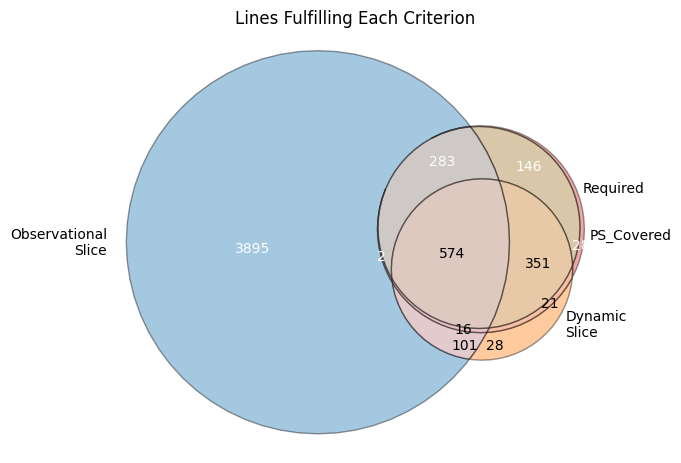

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib_set_diagrams import EulerDiagram, get_subsets

data_dir = '../project_data/'
df = pd.read_csv(data_dir + "all_projects.csv")
# df = pd.read_csv("../project_data/bvolpato_inutils4j_MyMapUtils/bvolpato_inutils4j_MyMapUtils.csv")
#project,class,line_no

df["unique_identifier"] = df["project"].astype(str) + df["class"].astype(str) + df["line_no"].astype(str)
df = df.sort_values('unique_identifier', ascending = True).reset_index(drop=True)

covered = set(df.loc[df['is_clover_covered'] == True, 'unique_identifier'].unique())
porbs = set(df.loc[df['on_porbs_slice'] == True, 'unique_identifier'].unique())
slicer4j = set(df.loc[df['on_slicer4j_slice'] == True, 'unique_identifier'].unique())
pseudosweep = set(df.loc[df['required_ps'] == True, 'unique_identifier'].unique())
cov = set(df.loc[df['covered_ps'] == True, 'unique_identifier'].unique())

print(porbs)

set_list = [
    porbs, 
    slicer4j, 
    pseudosweep,
    # covered, 
    cov
    ]

fig, ax = plt.subplots()

diagram = EulerDiagram.from_sets(
    set_list,
    ax=ax,
    set_labels=[
        "Observational\nSlice", 
        "Dynamic\nSlice",  
        "Required", 
        # "Statement\nCoverage",
        "\n\n\n\n\nPS_Covered"
        ],
)

print(get_subsets(set_list))

# Customize appearance using the correct attribute name: subset_artists
for artist in diagram.subset_artists.values():
    artist.set_alpha(0.4)
    artist.set_edgecolor("black")


plt.title("Lines Fulfilling Each Criterion")
plt.tight_layout()
plt.savefig("/Users/meganmaton/Repos/Papers/cc-orbs-ps-paper/graphics/rq2-coverage-gaps-euler.png", bbox_inches="tight")


## Calculating Slice and Required Intersections


In [2]:
cov_porbs = porbs.intersection(cov)
cov_slicer4j = slicer4j.intersection(cov)

# pairs
cov_porbs_slicer4j = cov_porbs.intersection(cov_slicer4j)
cov_porbs_pseudosweep = cov_porbs.intersection(pseudosweep)
cov_slicer4j_pseudosweep = cov_slicer4j.intersection(pseudosweep)

# overall
overall_intersection = cov_porbs_slicer4j.intersection(pseudosweep)

print("cov_porbs_slicer4j", len(cov_porbs_slicer4j))
print("cov_porbs_pseudosweep", len(cov_porbs_pseudosweep))
print("cov_slicer4j_pseudosweep", len(cov_slicer4j_pseudosweep))
print("overall_intersection", len(overall_intersection))

cov_porbs_slicer4j 590
cov_porbs_pseudosweep 857
cov_slicer4j_pseudosweep 925
overall_intersection 574


## Calculating Gap Intersections

In [3]:
# Cov Gaps
gap_porbs = cov.difference(porbs)
gap_slicer4j = cov.difference(slicer4j)
gap_pseudosweep = cov.difference(pseudosweep)

print("gap_porbs", gap_porbs)
print("gap_slicer4j", gap_slicer4j)
print("gap_pseudosweep",gap_pseudosweep)

# Gap Intersections
gap_porbs_slicer4j = gap_porbs.intersection(gap_slicer4j)
gap_porbs_pseudosweep = gap_porbs.intersection(gap_pseudosweep)
gap_slicer4j_pseudosweep = gap_slicer4j.intersection(gap_pseudosweep)
print("gap_porbs_slicer4j",gap_porbs_slicer4j)
print("gap_porbs_pseudosweep",gap_porbs_pseudosweep)
print("gap_slicer4j_pseudosweep", gap_slicer4j_pseudosweep)

overall_gap_intersection = gap_porbs.intersection(gap_slicer4j, gap_pseudosweep)
print("overall_gap_intersection", overall_gap_intersection)

gap_porbs {'bvolpato_inutils4jMyStringUtils439', 'facebook_facebook-java-business-sdkEvent353', 'bvolpato_inutils4jMyStringUtils402', 'tdebatty_java-string-similarityOptimalStringAlignment73', 'bvolpato_inutils4jMyStringUtils224', 'BlueObelisk_euclidTransform2138', 'bvolpato_inutils4jMyStringUtils329', 'bvolpato_inutils4jMyStringUtils433', 'decorators-squad_eo-yamlReadYamlMapping331', 'bvolpato_inutils4jMyStringUtils586', 'bvolpato_inutils4jMyStringUtils193', 'bvolpato_inutils4jMyStringUtils432', 'bvolpato_inutils4jMyStringUtils159', 'bvolpato_inutils4jMyStringUtils170', 'BlueObelisk_euclidTransform2509', 'bvolpato_inutils4jMyStringUtils1797', 'bvolpato_inutils4jMyStringUtils368', 'tdebatty_java-string-similarityNGram106', 'bvolpato_inutils4jMyStringUtils116', 'bvolpato_inutils4jMyStringUtils199', 'bvolpato_inutils4jMyStringUtils286', 'bvolpato_inutils4jMyStringUtils185', 'facebook_facebook-java-business-sdkServerSideApiUtil269', 'bvolpato_inutils4jMyStringUtils367', 'facebook_facebook

## Visualising the Coverage Gaps


In [4]:
def get_symbol(prefix, line) -> str:
    id = f'{prefix}{line}'
    
    # overall intersection
    if id in overall_gap_intersection:
        return r"$\blacksquare$", "overall_gap_intersection"
    
    # overlaps
    if id in gap_porbs_pseudosweep:
        return r"$\boxtimes$", "gap_porbs_pseudosweep"
    if id in gap_porbs_slicer4j:
        return r"$\boxminus$", "gap_porbs_slicer4j"
    if id in gap_slicer4j_pseudosweep:
        return r"$\boxplus$", "gap_slicer4j_pseudosweep"

    # individual 
    if id in gap_porbs:
        return r"$\circledcirc$", "gap_porbs"
    if id in gap_pseudosweep:
        return r"$\circleddash$", "gap_pseudosweep"
    if id in gap_slicer4j:
        return r"$\circledast$", "gap_slicer4j"
    return None, ""
    

In [5]:
df_visualize = pd.DataFrame()

statement_types = pd.DataFrame(columns=["Type", "Gap"])


for project, clazz in set(zip(df["project"], df["class"])):
    prefix = f"{project}{clazz}"
    line_total = len(df.loc[(df["project"] == project) & (df["class"] == clazz)])
    # print(prefix, line_total)

    symbols = []
    statement_types = pd.DataFrame(columns=["Type", "Gap"])

    # Stmt gap locations
    for line in range(1, line_total + 1):
        symbol_latex, gap = get_symbol(prefix, line)
        if symbol_latex is not None:
            # print(symbol_latex)
            symbols.append("\hgap" + symbol_latex.strip() + "\hgap")
        statement_type = df.loc[
            (df["project"] == project)
            & (df["class"] == clazz)
            & (df["line_no"] == line),
            "statement_type",
        ]
        if (len(statement_type)) > 0 and str(statement_type.values[0]) != "nan":
            statement_type = statement_type.values[0]
            statement_types.loc[len(statement_types)] = [statement_type, gap]
            # statement_types.loc[len(statement_types)] = [statement_type, ""]

    # Add to df
    # print("Symbols", len(symbols))
    symbols.sort()
    symbols.insert(0, clazz)
    symbols.insert(0, project)
    # symbols.insert(0, project.replace("_", "\_"))
    # join = r"\hgap".join(symbols)
    # symbol_string = f"$ {join}$"
    # df_visualize.loc[len(df_visualize)] = [project.replace("_","\_"), clazz, symbol_string]

    df_visualize = pd.concat([df_visualize, pd.DataFrame([symbols[:60]])])

    # print(len(df_visualize))
    # break # TODO: temp for debugging

# Output latex
df_visualize.sort_values([0,1], inplace=True)
df_visualize.drop([0], axis=1, inplace=True)
df_visualize.to_latex(
    # buf="/Users/meganmaton/Repos/Papers/cc-orbs-ps-paper/table-data/visual-gaps.tex",
    index=False,
    # columns=["project", "gaps"],
    na_rep="\hgap\hgap",
    )
print(df_visualize)

<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:53: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:19: SyntaxWarning: invalid escape sequence '\h'
<>:53: SyntaxWarning: invalid escape sequence '\h'
/var/folders/sl/yzy0v54s79q0hkrg6fzrf93h0000gn/T/ipykernel_4390/4168040335.py:19: SyntaxWarning: invalid escape sequence '\h'
  symbols.append("\hgap" + symbol_latex.strip() + "\hgap")
/var/folders/sl/yzy0v54s79q0hkrg6fzrf93h0000gn/T/ipykernel_4390/4168040335.py:19: SyntaxWarning: invalid escape sequence '\h'
  symbols.append("\hgap" + symbol_latex.strip() + "\hgap")
/var/folders/sl/yzy0v54s79q0hkrg6fzrf93h0000gn/T/ipykernel_4390/4168040335.py:53: SyntaxWarning: invalid escape sequence '\h'
  na_rep="\hgap\hgap",


                         1                         2   \
0                 Int2Range     \hgap$\boxminus$\hgap   
0           IntSquareMatrix  \hgap$\blacksquare$\hgap   
0                     Line2     \hgap$\boxminus$\hgap   
0                Real3Range   \hgap$\circledast$\hgap   
0                Transform2  \hgap$\blacksquare$\hgap   
0                MyArrUtils   \hgap$\circledast$\hgap   
0                MyMapUtils                       NaN   
0             MyNumberUtils  \hgap$\circleddash$\hgap   
0         MyReflectionUtils     \hgap$\boxminus$\hgap   
0             MyStringUtils  \hgap$\blacksquare$\hgap   
0              JsonYamlDump                       NaN   
0           ReadYamlMapping     \hgap$\boxminus$\hgap   
0            ReadYamlStream     \hgap$\boxminus$\hgap   
0                      Skip     \hgap$\boxminus$\hgap   
0              WellIndented     \hgap$\boxminus$\hgap   
0            BatchProcessor     \hgap$\boxminus$\hgap   
0       CAPIGatewayEndpoint   \


| Row | Category       | Reason                                                                                                                                                                        |
| --- | -------------- | ----------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 38  | $\boxtimes$    | on the slice for slicer4j, but porbs and pseudosweep both agree the statement is deletable without impacting test outcomes (manually confirmed)                               |
| 43  | $\boxminus$    | var dec was not influencing the oracle but pseudosweep could not set it to null without getting a null pointer later in the code                                              |
| 45  | $\blacksquare$ |                                                                                                                                                                               |
| 46  | $\blacksquare$ |                                                                                                                                                                               |
| 47  | $\blacksquare$ |                                                                                                                                                                               |
| 49  | $\boxtimes$    | on the slice for slicer4j, but porbs and pseudosweep both agree the statement is deletable without impacting test outcomes (manually confirmed)                               |
| 73  | $\circleddash$ | Row 73 was only in the PseudoSweep gap because PseudoSweep determined that the var dec could be initialised to null, whereas the slicers determined the var dec was required. |


Text(0.5, 1.0, 'Statement Types in Coverage Gaps')

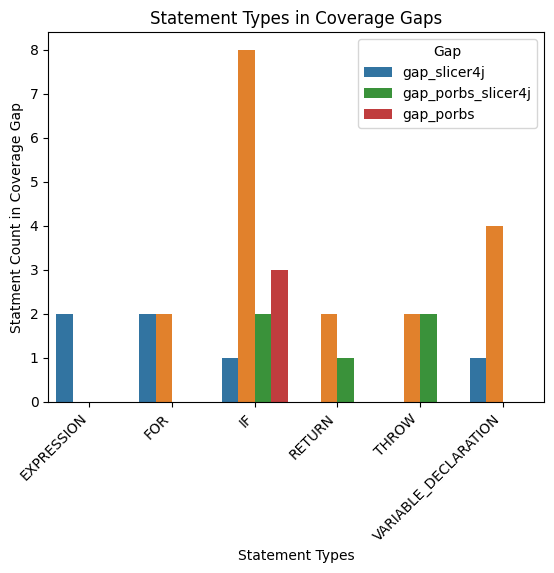

In [6]:
import seaborn as sns

# statement_type.plo
statement_types= statement_types.sort_values('Type', ascending = True).reset_index(drop=True)
sns.countplot(x=statement_types["Type"], hue=statement_types['Gap'], orient='h')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Statement Types')
plt.ylabel('Statment Count in Coverage Gap')
plt.title("Statement Types in Coverage Gaps")

# plt.savefig('/Users/meganm/Repos/Papers/cc-orbs-ps-paper/graphics/rq4-statement-type-countplot.png', bbox_inches="tight")

In [7]:
def jaccard_similarity(set1, set2):
  intersection = len(set1.intersection(set2))
  union = len(set1.union(set2))
  if union == 0:
    return 0.0 
  return intersection / union

def jaccard_distance(set1, set2):
  return 1 - jaccard_similarity(set1, set2)

# Calculate Jaccard similarities
jaccard_porbs_slicer4j = jaccard_similarity(gap_porbs, gap_slicer4j)
jaccard_porbs_pseudosweep = jaccard_similarity(gap_porbs, gap_pseudosweep)
jaccard_slicer4j_pseudosweep = jaccard_similarity(gap_slicer4j, gap_pseudosweep)


# Print the results
print(f"Jaccard similarity (gap_porbs, gap_slicer4j): {jaccard_porbs_slicer4j}")
print(f"Jaccard similarity (gap_porbs, gap_pseudosweep): {jaccard_porbs_pseudosweep}")
print(f"Jaccard similarity (gap_slicer4j, gap_pseudosweep): {jaccard_slicer4j_pseudosweep}")
print()

# Calculate Jaccard distances
distance_porbs_slicer4j = jaccard_distance(gap_porbs, gap_slicer4j)
distance_porbs_pseudosweep = jaccard_distance(gap_porbs, gap_pseudosweep)
distance_slicer4j_pseudosweep = jaccard_distance(gap_slicer4j, gap_pseudosweep)

# Print the results
print(f"Jaccard distance (gap_porbs, gap_slicer4j): {distance_porbs_slicer4j}")
print(f"Jaccard distance (gap_porbs, gap_pseudosweep): {distance_porbs_pseudosweep}")
print(f"Jaccard distance (gap_slicer4j, gap_pseudosweep): {distance_slicer4j_pseudosweep}")



Jaccard similarity (gap_porbs, gap_slicer4j): 0.20938628158844766
Jaccard similarity (gap_porbs, gap_pseudosweep): 0.08687943262411348
Jaccard similarity (gap_slicer4j, gap_pseudosweep): 0.06048387096774194

Jaccard distance (gap_porbs, gap_slicer4j): 0.7906137184115524
Jaccard distance (gap_porbs, gap_pseudosweep): 0.9131205673758865
Jaccard distance (gap_slicer4j, gap_pseudosweep): 0.939516129032258
